In [ ]:
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import scienceplots


base_path = "../data/raw_weights/"
file_name = "weight_distribution_{}_{}_{}.csv"


model_list = ['Llama-2-7b-hf', 'phi-2', 'Mistral-7B-v0.1', 'Baichuan-7B', 'Qwen2.5-7B'] 
dataset_list = ['c4', 'oscar', 'redpajama', 'pile', 'gsm8k', 'svamp', 'mawps', 'anli_r1', 'esnli', 'rte', 'boolq', 'commonsense_qa', 'race',
                'winogrande', 'wmt14', 'iwslt', 'opc', 'ds1000', 'mbpp', 'ellipses', 'random']

sparsity_list = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]


general_datasets = ['c4', 'oscar', 'redpajama', 'pile']
aritm_reasoning = ['gsm8k', 'svamp', 'mawps']
nlu_inference = ['anli_r1', 'esnli', 'rte']
commonsense_qa = ['boolq', 'commonsense_qa', 'race', 'winogrande']
translation = ['wmt14', 'iwslt']
non_sensical = ['ellipses', 'random']
coding = ['opc', 'ds1000', 'mbpp']
mixed = ['c4', 'gsm8k', 'anli_r1', 'boolq', 'wmt14']

all_categories = [general_datasets, aritm_reasoning, nlu_inference, commonsense_qa, translation, coding, non_sensical]
all_categories_names = ['general_datasets', 'aritm_reasoning', 'nlu_inference', 'commonsense_qa', 'translation', 'coding', 'non_sensical']

dictionary_id_name = {key: value for key, value in zip(dataset_list, range(len(dataset_list)))}
dictionary_name_id = {key: value for key, value in zip(range(len(dataset_list)), dataset_list)}
dictionary_id_group = {key: value for key, value in zip(range(len(all_categories_names)), all_categories_names)}


dictionary_dataset_to_category = {dataset: category for category, datasets in zip(all_categories_names, all_categories) for dataset in datasets}


all_categories_names_print = ['Language Modeling', 'Mathematical Reasoning', 'NLI', 'Question Answering', 'Translation', 'Coding', 'Nonsensical']
models_names_print = ['Llama', 'Phi', 'Mistral', 'Baichuan', 'Qwen']

rename_dictionary_category_names = {all_categories_names[i]: all_categories_names_print[i] for i in range(len(all_categories_names))} 
rename_dictionary_model_names = {model_list[i]: models_names_print[i] for i in range(len(model_list))}


plt.style.use('science')

sns.set_context("notebook", rc={
    "axes.linewidth": 0.5,
    "axes.titlesize": 22,
    "axes.labelsize": 18,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
})

In [2]:
#Create a custom color palette for the plot

original_cmap = sns.color_palette("Spectral_r", as_cmap=True) 
colors = np.concatenate((original_cmap(np.linspace(0, 0.35, 4)), original_cmap(np.linspace(0.7, 1, 4))), axis=0) # Extract 10 colors
custom_palette = np.clip(colors, 0, 1) # Ensure valid RGB range
custom_palette = [tuple(c) for c in custom_palette]  # Convert array to list of 


palette_heatmap =  sns.color_palette("Blues", as_cmap=True) 
colors_blues = np.concatenate((palette_heatmap(np.linspace(0, 0.35, 1)), palette_heatmap(np.linspace(0.8, 1, 10))), axis=0) # Extract 10 colors
custom_blues = np.clip(colors_blues, 0, 1) # Ensure valid RGB range
custom_blues = [tuple(c) for c in custom_blues]  # Convert array to list of 

one_color = sns.color_palette("mako", as_cmap=True).colors[190]

In [3]:
#Simplify dataframe

def simplify_dataframe(data, k=10):
    data['group'] = data.groupby(['model', 'layer', 'components', 'sparsity']).cumcount() // k
    
    
    aggregated = data.groupby(['model', 'layer', 'components', 'sparsity', 'group']).agg({
        'value': 'mean',
        'counter': 'sum',
        'percentage': 'sum',
        'total': 'first',
        'dataset': 'first',
        'category': 'first' # oppure 'mean', 'max', 'last' se preferisci
    }).reset_index()
    
    final_data = aggregated.drop(columns='group')

    return final_data

In [4]:
data_dense = pd.DataFrame()

for model in model_list:
    for dataset in dataset_list:
        file = f"{base_path}{file_name.format(model, '0.0', dataset)}"
        data = pd.read_csv(file)
        data['dataset'] = dataset
        
        data["percentage"] = data["counter"] / data["total"] * 100
        data["category"] = data["dataset"].apply(lambda x: dictionary_dataset_to_category[x])
        data["category"] = data["category"].replace(rename_dictionary_category_names)
        data["model"] = data["model"].replace(rename_dictionary_model_names)
        
        if "mode" not in data.columns:
            data["mode"] = "high_precision"
        
        #do an avg on every 10 values
        #data = simplify_dataframe(data, k=2)
        
        data_dense = pd.concat([data_dense, data], ignore_index=True)


data_dense_high_precision = data_dense[data_dense['mode'] == 'high_precision']
data_dense_high_range = data_dense[data_dense['mode'] == 'high_range']

In [5]:
data_sparse_high_precision = pd.DataFrame()
data_sparse_high_range = pd.DataFrame()

for model in model_list:  #Llama-2-7b-hf
    
    data_model_high_precision = pd.DataFrame()
    data_model_high_range = pd.DataFrame()
    
    for sparsity in sparsity_list:
        print(f"Processing model: {model}, sparsity: {sparsity}")
        for dataset in dataset_list:
            file = f"{base_path}{file_name.format(model, sparsity, dataset)}"
            data = pd.read_csv(file)
            
            data['dataset'] = dataset
        
            data["percentage"] = data["counter"] / data["total"] * 100
            data["category"] = data["dataset"].apply(lambda x: dictionary_dataset_to_category[x])
            data["category"] = data["category"].replace(rename_dictionary_category_names)
            data["model"] = data["model"].replace(rename_dictionary_model_names)
            
            #do an avg on every 10 values
            #data = simplify_dataframe(data, k=10)
            if "mode" not in data.columns:
                data["mode"] = "high_precision"
            #else:
            #    print(file)
            
            data_model_high_precision = pd.concat([data_model_high_precision, data[(data['value'] < 0.1) & (data['mode'] == 'high_precision')]], ignore_index=True)
            data_model_high_range = pd.concat([data_model_high_range, data[data['mode'] == 'high_range']], ignore_index=True)
    
    
    this_data_precision = data_model_high_precision.groupby(['model', 'sparsity', 'value', 'category']).agg({
        'counter': 'mean',
        'percentage': 'mean',
        'total': 'first'
    }).reset_index()
    data_sparse_high_precision = pd.concat([data_sparse_high_precision, this_data_precision], ignore_index=True)
    
    
    this_data_range = data_model_high_range.groupby(['model', 'sparsity', 'value', 'category']).agg({
        'counter': 'mean',
        'percentage': 'mean',
        'total': 'first'
    }).reset_index()
    data_sparse_high_range = pd.concat([data_sparse_high_range, this_data_range], ignore_index=True)


Processing model: Llama-2-7b-hf, sparsity: 0.0
Processing model: Llama-2-7b-hf, sparsity: 0.1
Processing model: Llama-2-7b-hf, sparsity: 0.3
Processing model: Llama-2-7b-hf, sparsity: 0.5
Processing model: Llama-2-7b-hf, sparsity: 0.7
Processing model: Llama-2-7b-hf, sparsity: 0.9
Processing model: phi-2, sparsity: 0.0
Processing model: phi-2, sparsity: 0.1
Processing model: phi-2, sparsity: 0.3
Processing model: phi-2, sparsity: 0.5
Processing model: phi-2, sparsity: 0.7
Processing model: phi-2, sparsity: 0.9
Processing model: Mistral-7B-v0.1, sparsity: 0.0
Processing model: Mistral-7B-v0.1, sparsity: 0.1
Processing model: Mistral-7B-v0.1, sparsity: 0.3
Processing model: Mistral-7B-v0.1, sparsity: 0.5
Processing model: Mistral-7B-v0.1, sparsity: 0.7
Processing model: Mistral-7B-v0.1, sparsity: 0.9
Processing model: Baichuan-7B, sparsity: 0.0
Processing model: Baichuan-7B, sparsity: 0.1
Processing model: Baichuan-7B, sparsity: 0.3
Processing model: Baichuan-7B, sparsity: 0.5
Processing

## DENSE

<>:21: SyntaxWarning: invalid escape sequence '\%'
<>:21: SyntaxWarning: invalid escape sequence '\%'
/var/folders/k2/frn908kd4_q13s9qm8hj9zcw0000gn/T/ipykernel_5846/494402156.py:21: SyntaxWarning: invalid escape sequence '\%'
  """


97.02342418709341
43.73377619901108


/var/folders/k2/frn908kd4_q13s9qm8hj9zcw0000gn/T/ipykernel_5846/494402156.py:29: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(data=limited_results, x="value", y="percentage", hue="category", palette=custom_palette, ax=ax[1], hue_order = all_categories_names_print, linewidth=3)


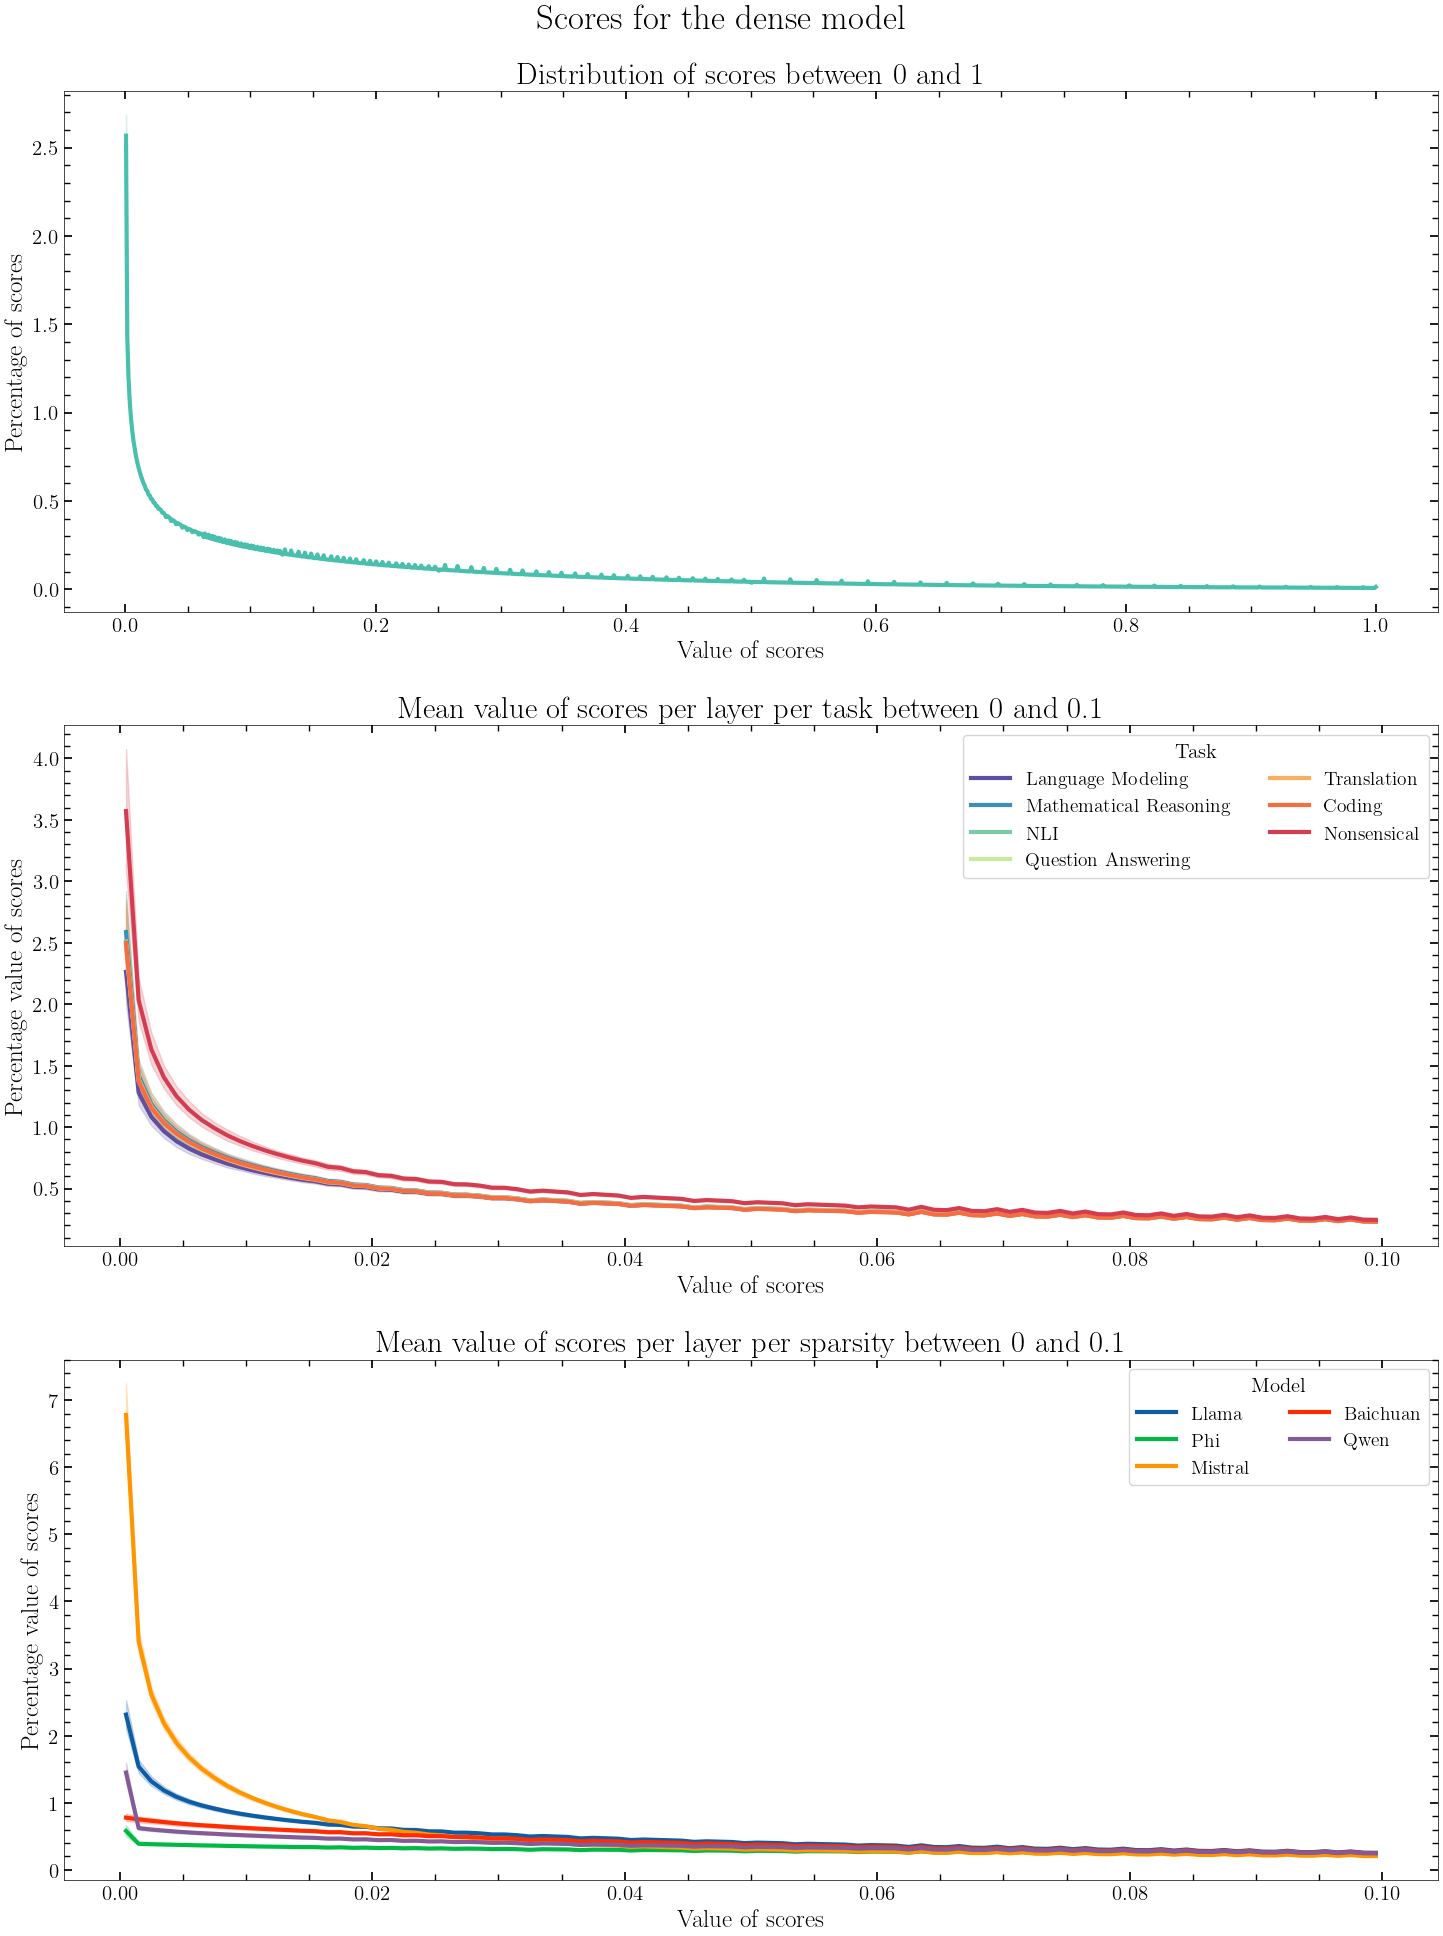

In [6]:
figure, ax = plt.subplots(3, figsize=(15, 20))

low_cut_off_value = 0 #0.005
high_cut_off_value = 0.1 #0.005

mean_result_across_datasets = data_dense_high_precision.groupby(["model", "layer", "components", "value", "dataset", "category"]).mean(numeric_only=True).reset_index()
limited_results =  mean_result_across_datasets[(mean_result_across_datasets["value"] > low_cut_off_value) & (mean_result_across_datasets["value"] < high_cut_off_value)]
this_data_no_non_sensical_limited = limited_results[limited_results["category"] != "non_sensical"]
this_data_no_non_sensical_unlimited = mean_result_across_datasets[mean_result_across_datasets["category"] != "non_sensical"]


print((this_data_no_non_sensical_unlimited.groupby(["model", "layer", "components", "sparsity", "dataset"])["percentage"].sum()).mean())
print((this_data_no_non_sensical_limited.groupby(["model", "layer", "components", "sparsity", "dataset"])["percentage"].sum()).mean())

#Show the distribution between 0 and 1
sns.lineplot(data=this_data_no_non_sensical_unlimited, x="value", y="percentage", color=one_color, ax=ax[0], linewidth=3)
ax[0].set_title("Distribution of scores between 0 and 1") #\n(97\% of all scores)")
ax[0].set_ylabel("Percentage of scores")
ax[0].set_xlabel("Value of scores")

"""
sns.lineplot(data=this_data_no_non_sensical_limited, x="value", y="percentage", color=one_color, ax=ax[1])
ax[1].set_title("Distribution of scores between 0 and 0.1\n(45\% of all scores)")
ax[1].set_ylabel("Percentage of scores")
ax[1].set_xlabel("Value of scores")
"""

#Group by task
sns.lineplot(data=limited_results, x="value", y="percentage", hue="category", palette=custom_palette, ax=ax[1], hue_order = all_categories_names_print, linewidth=3)
ax[1].set_title("Mean value of scores per layer per task between 0 and 0.1") #\n(45\% of all scores)")
ax[1].set_ylabel("Percentage value of scores")
ax[1].set_xlabel("Value of scores")
ax[1].legend(title="Task", loc='upper right',  title_fontsize=15, fontsize=14, ncol=2, frameon=True)


sns.lineplot(data=this_data_no_non_sensical_limited, x="value", y="percentage", hue="model", color=one_color, ax=ax[2], hue_order=models_names_print, linewidth=3)
ax[2].set_title("Mean value of scores per layer per sparsity between 0 and 0.1") #\n(45\% of all scores)")
ax[2].set_ylabel("Percentage value of scores")
ax[2].set_xlabel("Value of scores")
ax[2].legend(title="Model", loc='upper right',  title_fontsize=15, fontsize=14, ncol=2, frameon=True)


figure.suptitle("Scores for the dense model", fontsize=25)
figure.tight_layout(pad=2.0)

## SPARSE

45.273948649886144
51.65641399826379


/var/folders/k2/frn908kd4_q13s9qm8hj9zcw0000gn/T/ipykernel_5846/3321085487.py:23: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(data=this_data[this_data["sparsity"] == 0.9], x="value", y="percentage", hue="category", color=one_color, ax=ax[1], palette=custom_palette, hue_order=all_categories_names_print, linewidth=3)


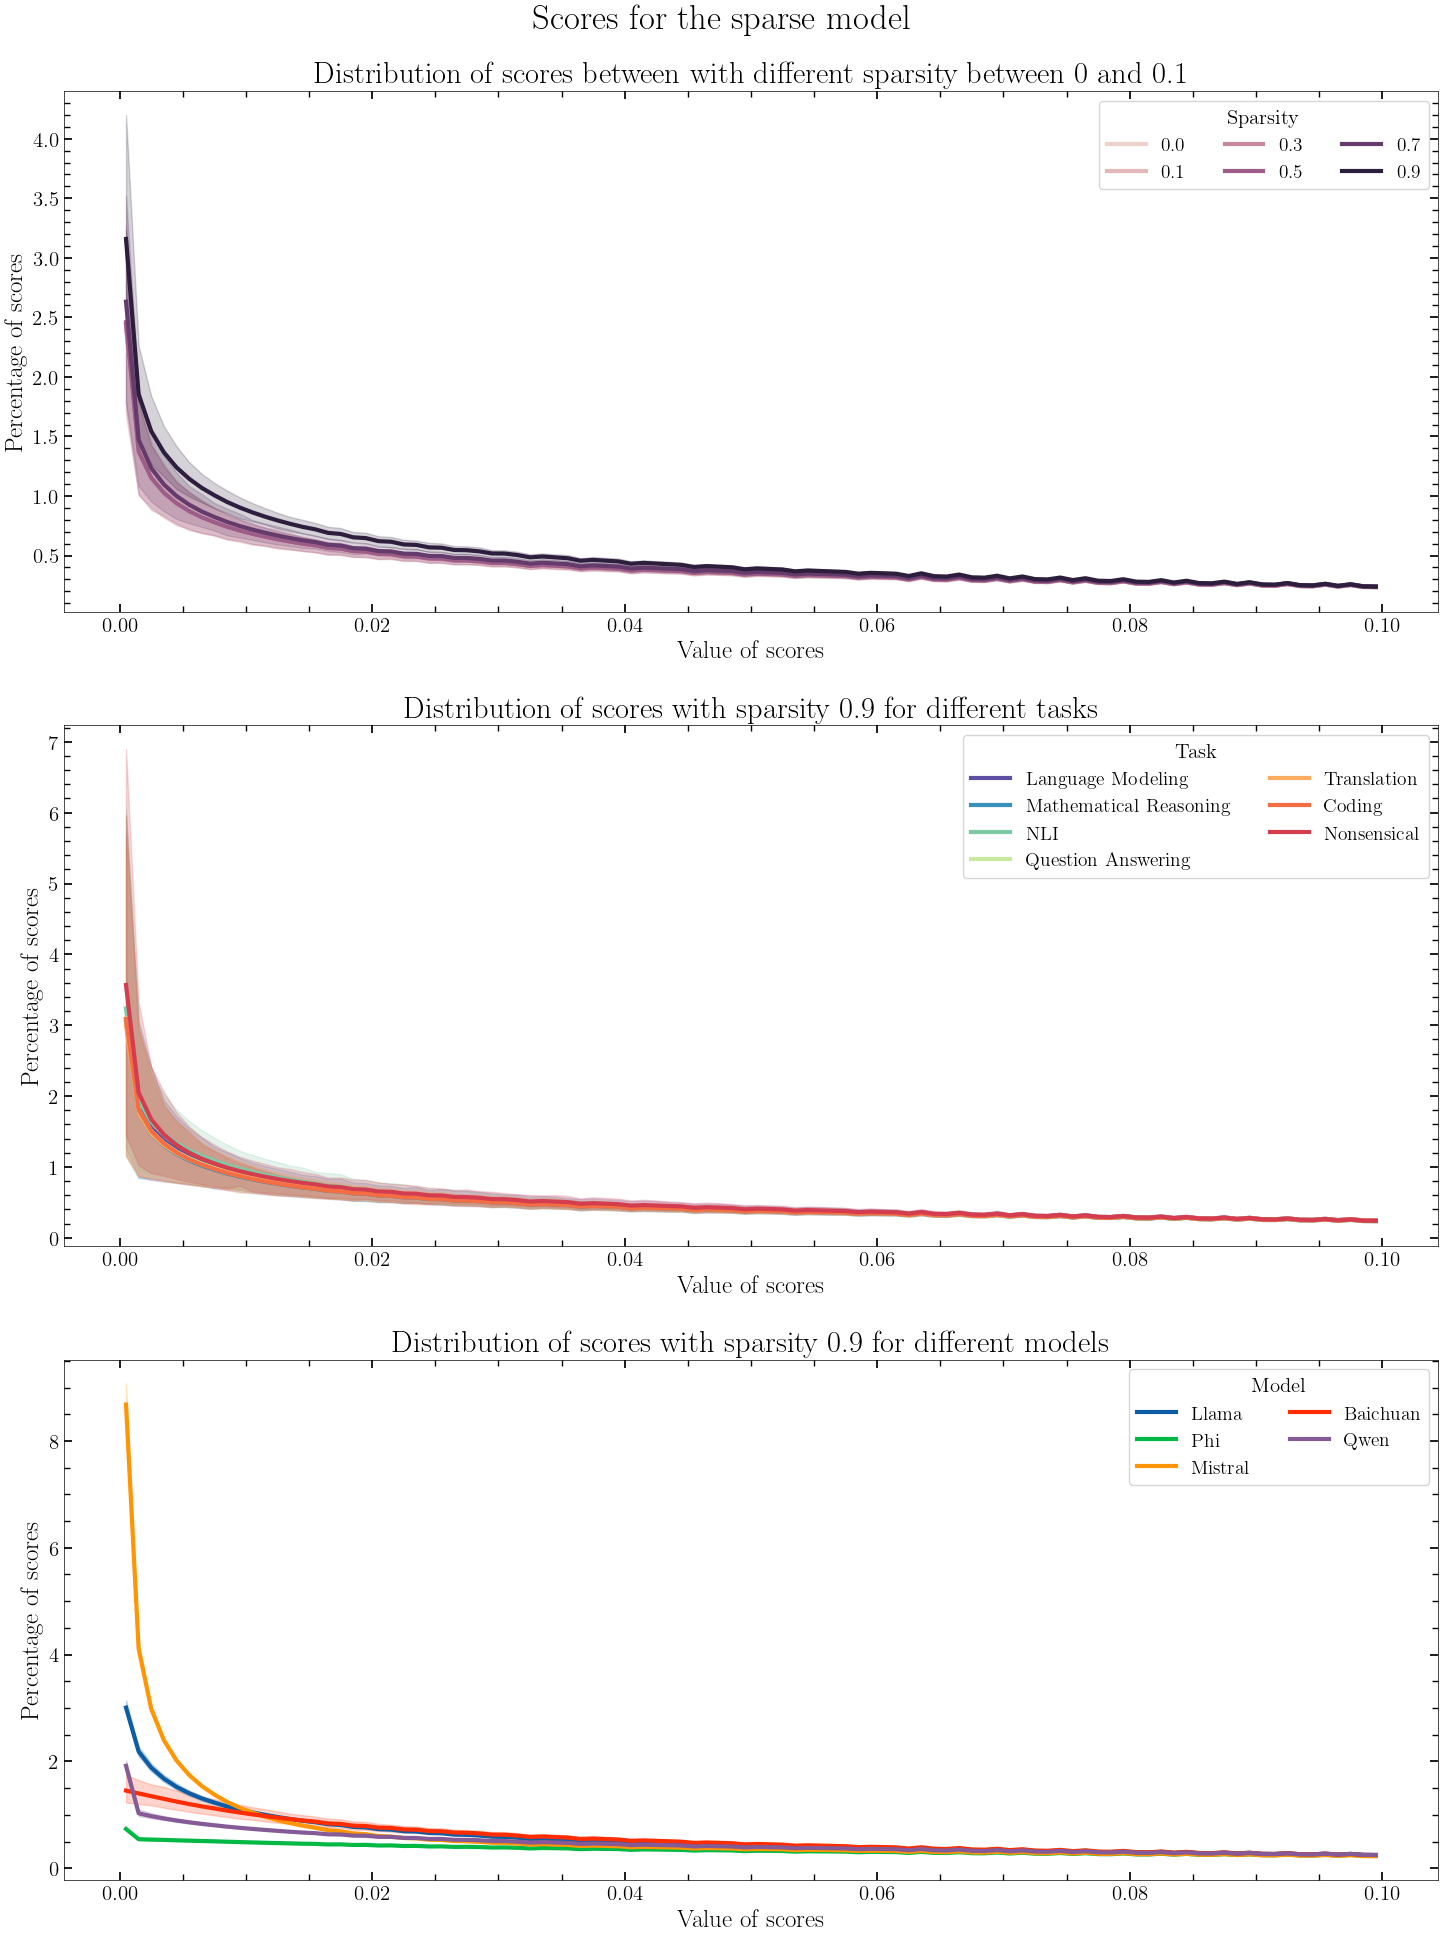

In [7]:
figure, ax = plt.subplots(3, figsize=(15, 20))

this_data = data_sparse_high_precision[data_sparse_high_precision["value"] < 0.1] #[data_sparse["model"] == "phi-2"]
#this_data = data_sparse[data_sparse["model"] == "phi-2"]
#this_data = data_sparse[(data_sparse["sparsity"] == 0.0) | (data_sparse["sparsity"] == 0.1)]

x_lim = 0.1
y_lim = 3

print((this_data.groupby(["model", "sparsity", "category"])["percentage"].sum()).mean())
print((this_data[this_data["sparsity"] == 0.9].groupby(["model", "sparsity", "category"])["percentage"].sum()).mean())

#Show the distribution between 0 and 1
sns.lineplot(data=this_data, x="value", y="percentage", hue="sparsity", color=one_color, ax=ax[0], linewidth=3)
ax[0].set_title("Distribution of scores between with different sparsity between 0 and 0.1") #\n(47\% of all scores)")
#ax[0].set_xlim(0, x_lim)
#ax[0].set_ylim(0, y_lim)
ax[0].set_ylabel("Percentage of scores")
ax[0].set_xlabel("Value of scores")
ax[0].legend(title="Sparsity", loc='upper right', title_fontsize=15, fontsize=14, ncol=3, frameon=True)


sns.lineplot(data=this_data[this_data["sparsity"] == 0.9], x="value", y="percentage", hue="category", color=one_color, ax=ax[1], palette=custom_palette, hue_order=all_categories_names_print, linewidth=3)
ax[1].set_title("Distribution of scores with sparsity 0.9 for different tasks") #\n(54\% of all scores)")
#ax[1].set_xlim(0, x_lim)
#ax[1].set_ylim(0, 7)
ax[1].set_ylabel("Percentage of scores")
ax[1].set_xlabel("Value of scores")
ax[1].legend(title="Task", loc='upper right',  title_fontsize=15, fontsize=14, ncol=2, frameon=True)


sns.lineplot(data=this_data[this_data["sparsity"] == 0.9], x="value", y="percentage", hue="model", color=one_color, ax=ax[2], hue_order=models_names_print, linewidth=3)
ax[2].set_title("Distribution of scores with sparsity 0.9 for different models") #\n(54\% of all scores)")
#ax[2].set_xlim(0, x_lim)
#ax[2].set_ylim(0, 7)
ax[2].set_ylabel("Percentage of scores")
ax[2].set_xlabel("Value of scores")
ax[2].legend(title="Model", loc='upper right',  title_fontsize=15, fontsize=14, ncol=2, frameon=True)#, bbox_to_anchor=(0, 0, 1, 0.98))


figure.suptitle("Scores for the sparse model", fontsize=25)
figure.tight_layout(pad=2.0)

In [8]:
#Table of weights
data_groupped = data_sparse_high_range.groupby(["sparsity", "value"])["percentage"].mean().reset_index()
data_groupped['from'] = data_groupped['value'].apply(lambda x: math.floor(x))
data_groupped['to'] = data_groupped['value'].apply(lambda x: math.ceil(x))

data_groupped_limited = data_groupped[data_groupped['to'] <= 10]

pivot_table = pd.pivot_table(
    data_groupped_limited,
    values='percentage',
    index=['from', 'to'],
)

display(pivot_table)
print(pivot_table.to_latex())

,,percentage
from,to,
0,1,96.954691
1,2,2.578346
2,3,0.267389
3,4,0.080589
4,5,0.036794
5,6,0.020434
6,7,0.012726
7,8,0.008585
8,9,0.006118


\begin{tabular}{llr}
\toprule
 &  & percentage \\
from & to &  \\
\midrule
0 & 1 & 96.954691 \\
\cline{1-3}
1 & 2 & 2.578346 \\
\cline{1-3}
2 & 3 & 0.267389 \\
\cline{1-3}
3 & 4 & 0.080589 \\
\cline{1-3}
4 & 5 & 0.036794 \\
\cline{1-3}
5 & 6 & 0.020434 \\
\cline{1-3}
6 & 7 & 0.012726 \\
\cline{1-3}
7 & 8 & 0.008585 \\
\cline{1-3}
8 & 9 & 0.006118 \\
\cline{1-3}
9 & 10 & 0.004563 \\
\cline{1-3}
\bottomrule
\end{tabular}



<h1>Different model sizes</h1>

In [9]:
model_list = ['Qwen2.5-0.5B', 'Qwen2.5-1.5B', 'Qwen2.5-3B', 'Qwen2.5-7B', 'Qwen2.5-14B'] 


data_sparse_high_precision_diff_size = pd.DataFrame()
data_sparse_high_range_diff_size = pd.DataFrame()

for model in model_list:  #Llama-2-7b-hf
    
    data_model_high_precision_diff_size = pd.DataFrame()
    data_model_high_range_diff_size = pd.DataFrame()
    
    for sparsity in sparsity_list:
        print(f"Processing model: {model}, sparsity: {sparsity}")
        file = f"{base_path}{file_name.format(model, sparsity, "all")}"
        data = pd.read_csv(file)
        
        data['dataset'] = 'all'
    
        data["percentage"] = data["counter"] / data["total"] * 100
        
        #do an avg on every 10 values
        #data = simplify_dataframe(data, k=10)
        if "mode" not in data.columns:
            data["mode"] = "high_precision"
        #else:
        #    print(file)
        
        data_model_high_precision_diff_size = pd.concat([data_model_high_precision_diff_size, data[(data['value'] < 0.1) & (data['mode'] == 'high_precision')]], ignore_index=True)
        data_model_high_range_diff_size = pd.concat([data_model_high_range_diff_size, data[data['mode'] == 'high_range']], ignore_index=True)

    
    this_data_precision_diff_size = data_model_high_precision_diff_size.groupby(['model', 'sparsity', 'value']).agg({
        'counter': 'mean',
        'percentage': 'mean',
        'total': 'first'
    }).reset_index()
    data_sparse_high_precision_diff_size = pd.concat([data_sparse_high_precision_diff_size, this_data_precision_diff_size], ignore_index=True)
    
    
    this_data_range_diff_size = data_model_high_range_diff_size.groupby(['model', 'sparsity', 'value']).agg({
        'counter': 'mean',
        'percentage': 'mean',
        'total': 'first'
    }).reset_index()
    data_sparse_high_range_diff_size = pd.concat([data_sparse_high_range_diff_size, this_data_range_diff_size], ignore_index=True)


Processing model: Qwen2.5-0.5B, sparsity: 0.0
Processing model: Qwen2.5-0.5B, sparsity: 0.1
Processing model: Qwen2.5-0.5B, sparsity: 0.3
Processing model: Qwen2.5-0.5B, sparsity: 0.5
Processing model: Qwen2.5-0.5B, sparsity: 0.7
Processing model: Qwen2.5-0.5B, sparsity: 0.9
Processing model: Qwen2.5-1.5B, sparsity: 0.0
Processing model: Qwen2.5-1.5B, sparsity: 0.1
Processing model: Qwen2.5-1.5B, sparsity: 0.3
Processing model: Qwen2.5-1.5B, sparsity: 0.5
Processing model: Qwen2.5-1.5B, sparsity: 0.7
Processing model: Qwen2.5-1.5B, sparsity: 0.9
Processing model: Qwen2.5-3B, sparsity: 0.0
Processing model: Qwen2.5-3B, sparsity: 0.1
Processing model: Qwen2.5-3B, sparsity: 0.3
Processing model: Qwen2.5-3B, sparsity: 0.5
Processing model: Qwen2.5-3B, sparsity: 0.7
Processing model: Qwen2.5-3B, sparsity: 0.9
Processing model: Qwen2.5-7B, sparsity: 0.0
Processing model: Qwen2.5-7B, sparsity: 0.1
Processing model: Qwen2.5-7B, sparsity: 0.3
Processing model: Qwen2.5-7B, sparsity: 0.5
Processi

             model  sparsity   value        counter  percentage     total
0     Qwen2.5-0.5B       0.0  0.0005    9196.250000    0.512326    802816
1     Qwen2.5-0.5B       0.0  0.0015    8261.428571    0.459941    802816
2     Qwen2.5-0.5B       0.0  0.0025    7925.226190    0.419113    802816
3     Qwen2.5-0.5B       0.0  0.0035    7713.916667    0.392282    802816
4     Qwen2.5-0.5B       0.0  0.0045    7541.125000    0.372368    802816
...            ...       ...     ...            ...         ...       ...
2995   Qwen2.5-14B       0.9  0.0955  100243.800595    0.260773  26214400
2996   Qwen2.5-14B       0.9  0.0965   93314.032738    0.243108  26214400
2997   Qwen2.5-14B       0.9  0.0975   98421.532738    0.256255  26214400
2998   Qwen2.5-14B       0.9  0.0985   91772.607143    0.239238  26214400
2999   Qwen2.5-14B       0.9  0.0995   91015.404762    0.237324  26214400

[3000 rows x 6 columns]
31.044398541556593
36.95114960748794
99.92225410306017


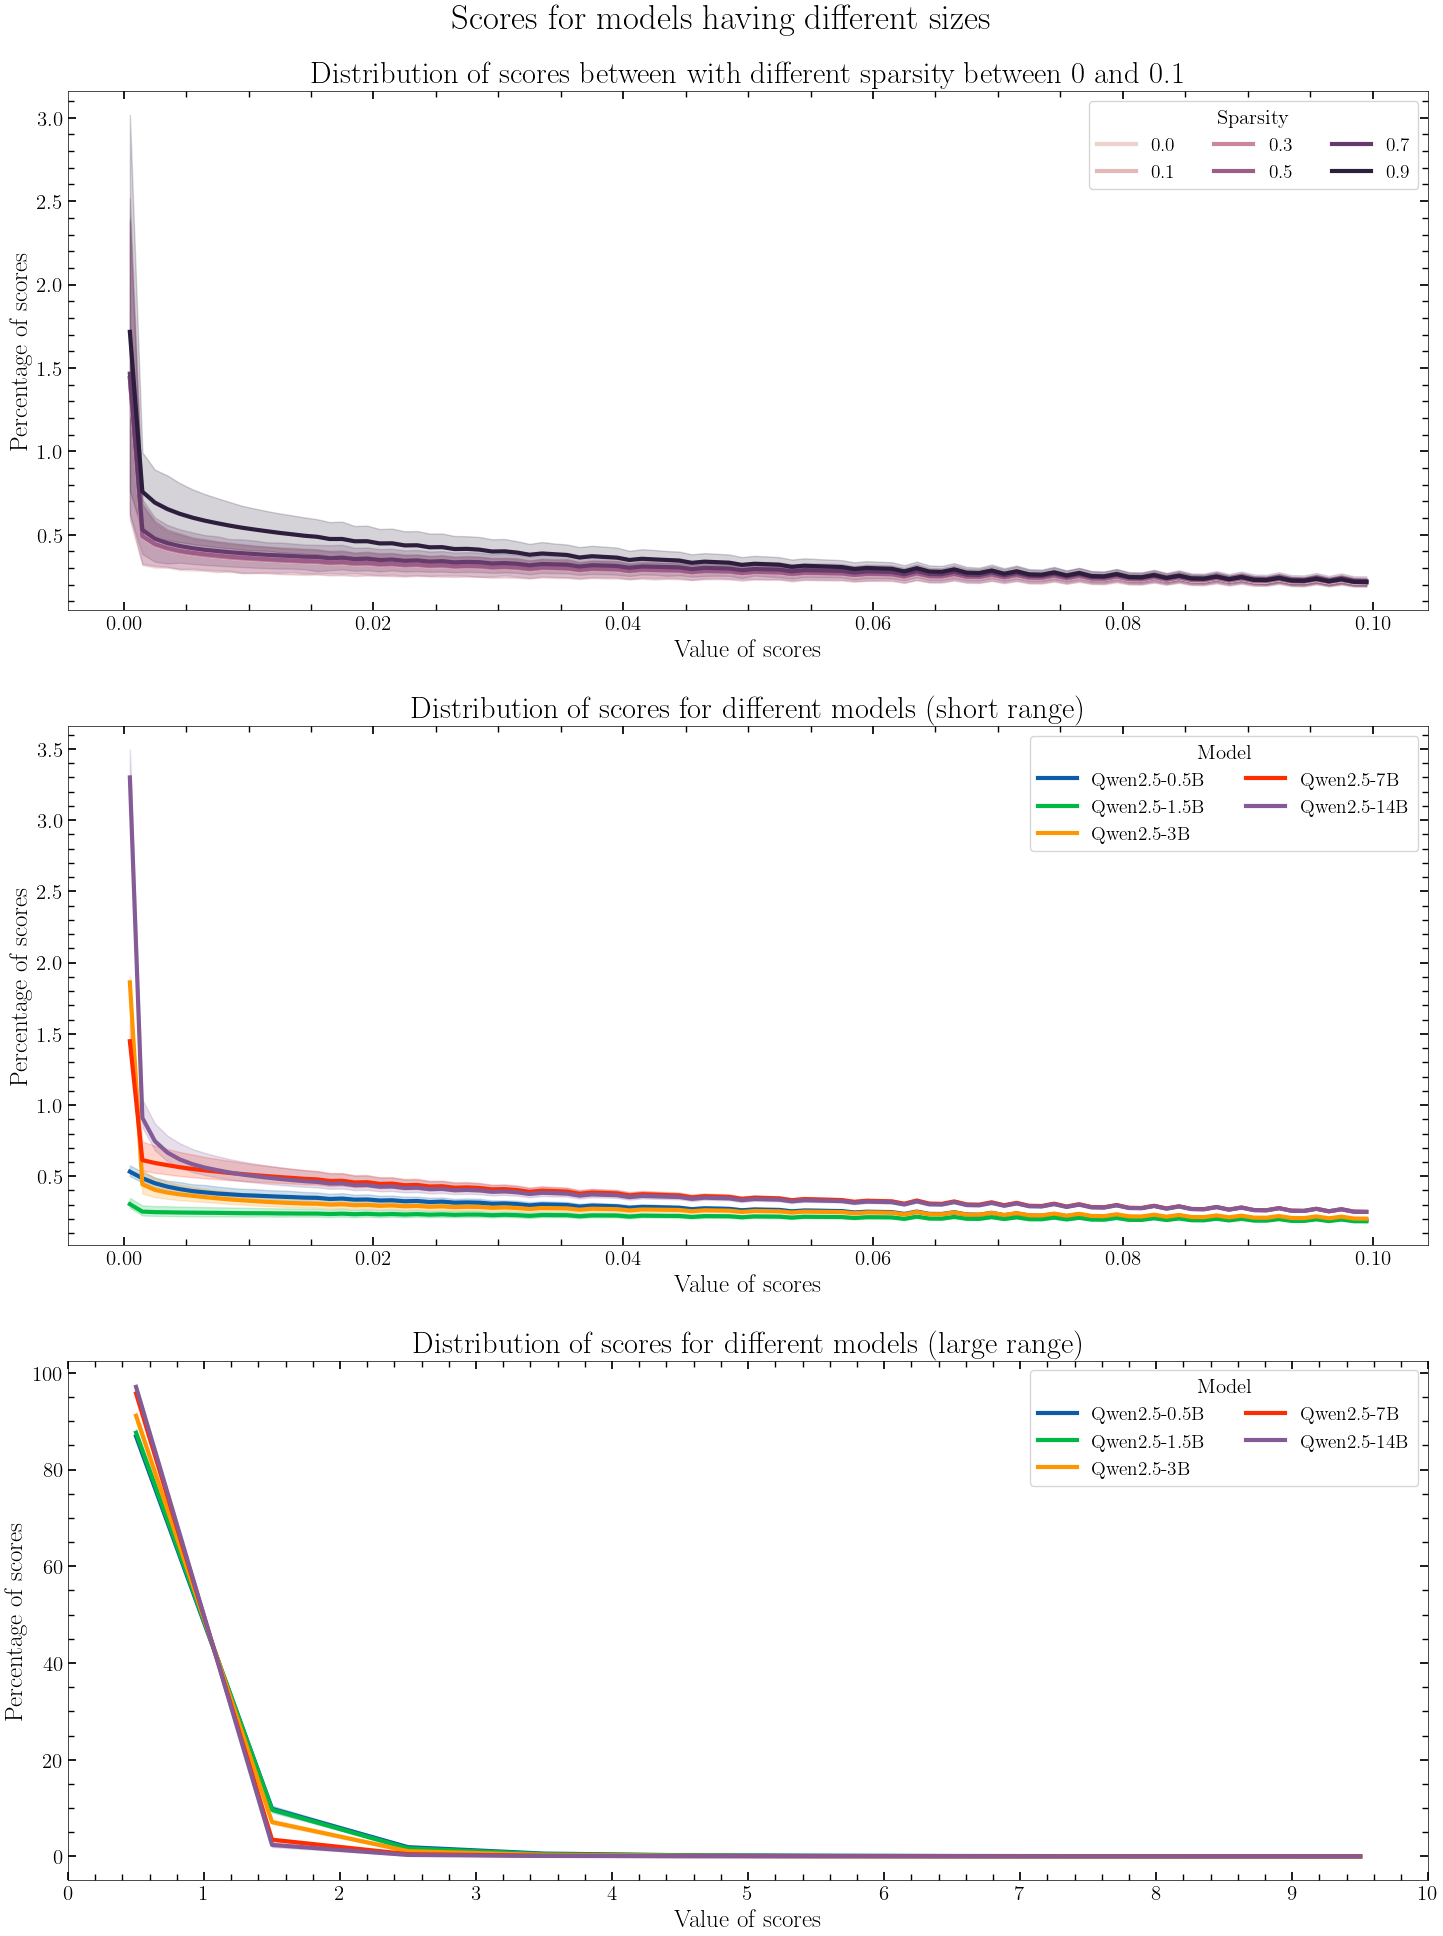

In [10]:
figure, ax = plt.subplots(3, figsize=(15, 20))

this_data = data_sparse_high_precision_diff_size
#this_data = data_sparse_high_range_diff_size
#this_data = data_sparse[data_sparse["model"] == "phi-2"]
#this_data = data_sparse[(data_sparse["sparsity"] == 0.0) | (data_sparse["sparsity"] == 0.1)]

x_lim = 0.1
y_lim = 3
print(this_data)
print((this_data.groupby(["model", "sparsity"])["percentage"].sum()).mean())
print((this_data[this_data["sparsity"] == 0.9].groupby(["model"])["percentage"].sum()).mean())

#Show the distribution between 0 and 1
sns.lineplot(data=this_data, x="value", y="percentage", hue="sparsity", color=one_color, ax=ax[0], linewidth=3)
ax[0].set_title("Distribution of scores between with different sparsity between 0 and 0.1") #\n(31\% of all scores)")
ax[0].set_ylabel("Percentage of scores")
ax[0].set_xlabel("Value of scores")
ax[0].legend(title="Sparsity", loc='upper right',  title_fontsize=15, fontsize=14, ncol=3, frameon=True)


sns.lineplot(data=this_data, x="value", y="percentage",  hue="model", color=one_color, ax=ax[1], linewidth=3)
ax[1].set_title("Distribution of scores for different models (short range)") #\n(37\% of all scores)")
ax[1].set_ylabel("Percentage of scores")
ax[1].set_xlabel("Value of scores")
ax[1].legend(title="Model", loc='upper right',  title_fontsize=15, fontsize=14, ncol=2, frameon=True)


print((data_sparse_high_range_diff_size[data_sparse_high_range_diff_size["value"]<=10].groupby(["model", "sparsity"])["percentage"].sum()).mean())

sns.lineplot(data=data_sparse_high_range_diff_size[data_sparse_high_range_diff_size["value"]<=10], x="value", y="percentage", hue="model", color=one_color, ax=ax[2], hue_order=model_list, linewidth=3)
ax[2].set_title("Distribution of scores for different models (large range)") #\n(99\% of all scores)")
ax[2].set_ylabel("Percentage of scores")
ax[2].set_xlabel("Value of scores")
ax[2].legend(title="Model", loc='upper right',  title_fontsize=15, fontsize=14, ncol=2, frameon=True)#, bbox_to_anchor=(0, 0, 1, 0.98))
ax[2].set_xticks(np.arange(0, 11, 1))  # Set x-ticks from 0 to 10 with step 1
ax[2].set_xticklabels(np.arange(0, 11, 1))  # Set x-tick labels and rotate them for better visibility


figure.suptitle("Scores for models having different sizes", fontsize=25)
figure.tight_layout(pad=2.0)

<h1> Results weights value:</h1>

In [ ]:

import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots


base_path = "../data/raw_weights/"
file_name = "weight_value_{}_{}_{}.csv"


model_list = ['Llama-2-7b-hf', 'phi-2', 'Mistral-7B-v0.1', 'Baichuan-7B', 'Qwen2.5-7B']
dataset_list = ['c4', 'oscar', 'redpajama', 'pile', 'gsm8k', 'svamp', 'mawps', 'anli_r1', 'esnli', 'rte', 'boolq', 'commonsense_qa', 'race',
                'winogrande', 'wmt14', 'iwslt', 'opc', 'ds1000', 'mbpp', 'ellipses', 'random']


sparsity_list = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]


general_datasets = ['c4', 'oscar', 'redpajama', 'pile']
aritm_reasoning = ['gsm8k', 'svamp', 'mawps']
nlu_inference = ['anli_r1', 'esnli', 'rte']
commonsense_qa = ['boolq', 'commonsense_qa', 'race', 'winogrande']
translation = ['wmt14', 'iwslt']
non_sensical = ['ellipses', 'random']
coding = ['opc', 'ds1000', 'mbpp']

mixed = ['c4', 'gsm8k', 'anli_r1', 'boolq', 'wmt14']

all_categories = [general_datasets, aritm_reasoning, nlu_inference, commonsense_qa, translation, coding, non_sensical]
all_categories_names = ['general_datasets', 'aritm_reasoning', 'nlu_inference', 'commonsense_qa', 'translation', 'coding', 'non_sensical']

dictionary_id_name = {key: value for key, value in zip(dataset_list, range(len(dataset_list)))}
dictionary_name_id = {key: value for key, value in zip(range(len(dataset_list)), dataset_list)}
dictionary_id_group = {key: value for key, value in zip(range(len(all_categories_names)), all_categories_names)}


dictionary_dataset_to_category = {dataset: category for category, datasets in zip(all_categories_names, all_categories) for dataset in datasets}



all_categories_names = ['general_datasets', 'aritm_reasoning', 'nlu_inference', 'commonsense_qa', 'translation', 'coding', 'non_sensical']
all_categories_names_print = ['Language Modeling', 'Mathematical Reasoning', 'NLI', 'Question Answering', 'Translation', 'Coding', 'Non sensical']

models_names_print = ['Llama', 'Phi', 'Mistral', 'Baichuan', 'Qwen']

rename_dictionary_category_names = {all_categories_names[i]: all_categories_names_print[i] for i in range(len(all_categories_names))} 

plt.style.use('science')

In [ ]:
path = "../data/processed_data/specs_layers.csv"
name_csv = pd.read_csv(path)
name_csv = name_csv[name_csv["layer"]==0]
#print(name_csv)

dictionary_components = {}

for model in model_list:
    print(model)
    model_data = name_csv[name_csv["model"]==model]
    
    components_names = [model_data.iloc[i]["name"] for i in range(len(model_data))]
    
    components_ids = range(1, len(components_names) + 1)

    dictionary_model = {key: value for key, value in zip(components_ids, components_names)}
    dictionary_components[model] = dictionary_model

print(dictionary_components)

Llama-2-7b-hf
phi-2
Mistral-7B-v0.1
Baichuan-7B
Qwen2.5-7B
{'Llama-2-7b-hf': {1: 'self_attn.q_proj', 2: 'self_attn.k_proj', 3: 'self_attn.v_proj', 4: 'self_attn.o_proj', 5: 'mlp.gate_proj', 6: 'mlp.up_proj', 7: 'mlp.down_proj'}, 'phi-2': {1: 'self_attn.q_proj', 2: 'self_attn.k_proj', 3: 'self_attn.v_proj', 4: 'self_attn.dense', 5: 'mlp.fc1', 6: 'mlp.fc2'}, 'Mistral-7B-v0.1': {1: 'self_attn.q_proj', 2: 'self_attn.k_proj', 3: 'self_attn.v_proj', 4: 'self_attn.o_proj', 5: 'mlp.gate_proj', 6: 'mlp.up_proj', 7: 'mlp.down_proj'}, 'Baichuan-7B': {1: 'self_attn.W_pack', 2: 'self_attn.o_proj', 3: 'mlp.gate_proj', 4: 'mlp.down_proj', 5: 'mlp.up_proj'}, 'Qwen2.5-7B': {1: 'self_attn.q_proj', 2: 'self_attn.k_proj', 3: 'self_attn.v_proj', 4: 'self_attn.o_proj', 5: 'mlp.gate_proj', 6: 'mlp.up_proj', 7: 'mlp.down_proj'}}


In [13]:
#Create a custom color palette for the plot

original_cmap = sns.color_palette("Spectral_r", as_cmap=True) 
colors = np.concatenate((original_cmap(np.linspace(0, 0.35, 4)), original_cmap(np.linspace(0.7, 1, 4))), axis=0) # Extract 10 colors
custom_palette = np.clip(colors, 0, 1) # Ensure valid RGB range
custom_palette = [tuple(c) for c in custom_palette]  # Convert array to list of 


palette_heatmap =  sns.color_palette("Blues", as_cmap=True) 
colors_blues = np.concatenate((palette_heatmap(np.linspace(0, 0.35, 1)), palette_heatmap(np.linspace(0.8, 1, 10))), axis=0) # Extract 10 colors
custom_blues = np.clip(colors_blues, 0, 1) # Ensure valid RGB range
custom_blues = [tuple(c) for c in custom_blues]  # Convert array to list of 

one_color = sns.color_palette("mako", as_cmap=True).colors[190]

In [14]:
data_weight_value = pd.DataFrame()
for model in model_list:
    for sparsity in sparsity_list:
        for dataset in dataset_list:
            file = f"{base_path}{file_name.format(model, sparsity, dataset)}"
            data = pd.read_csv(file)
            data['dataset'] = dataset
            data_weight_value = pd.concat([data_weight_value, data], ignore_index=True)

#data_weight_value["percentage"] = data_weight_value["counter"] / data_weight_value["total"] * 100
data_weight_value["category"] = data_weight_value["dataset"].apply(lambda x: dictionary_dataset_to_category[x])

data_weight_value.rename(columns={"sparsiry": "sparsity"}, inplace=True)

data_weight_value["category"] = data_weight_value["category"].apply(lambda x: rename_dictionary_category_names[x] if x in rename_dictionary_category_names else x)


/var/folders/k2/frn908kd4_q13s9qm8hj9zcw0000gn/T/ipykernel_5846/1021079639.py:25: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(data=mean_result_across_datasets[mean_result_across_datasets["model"] != "Qwen2.5-7B"], x="layer", y="value", hue="category", palette=custom_palette, ax=ax[2], hue_order = all_categories_names_print, linewidth=3)


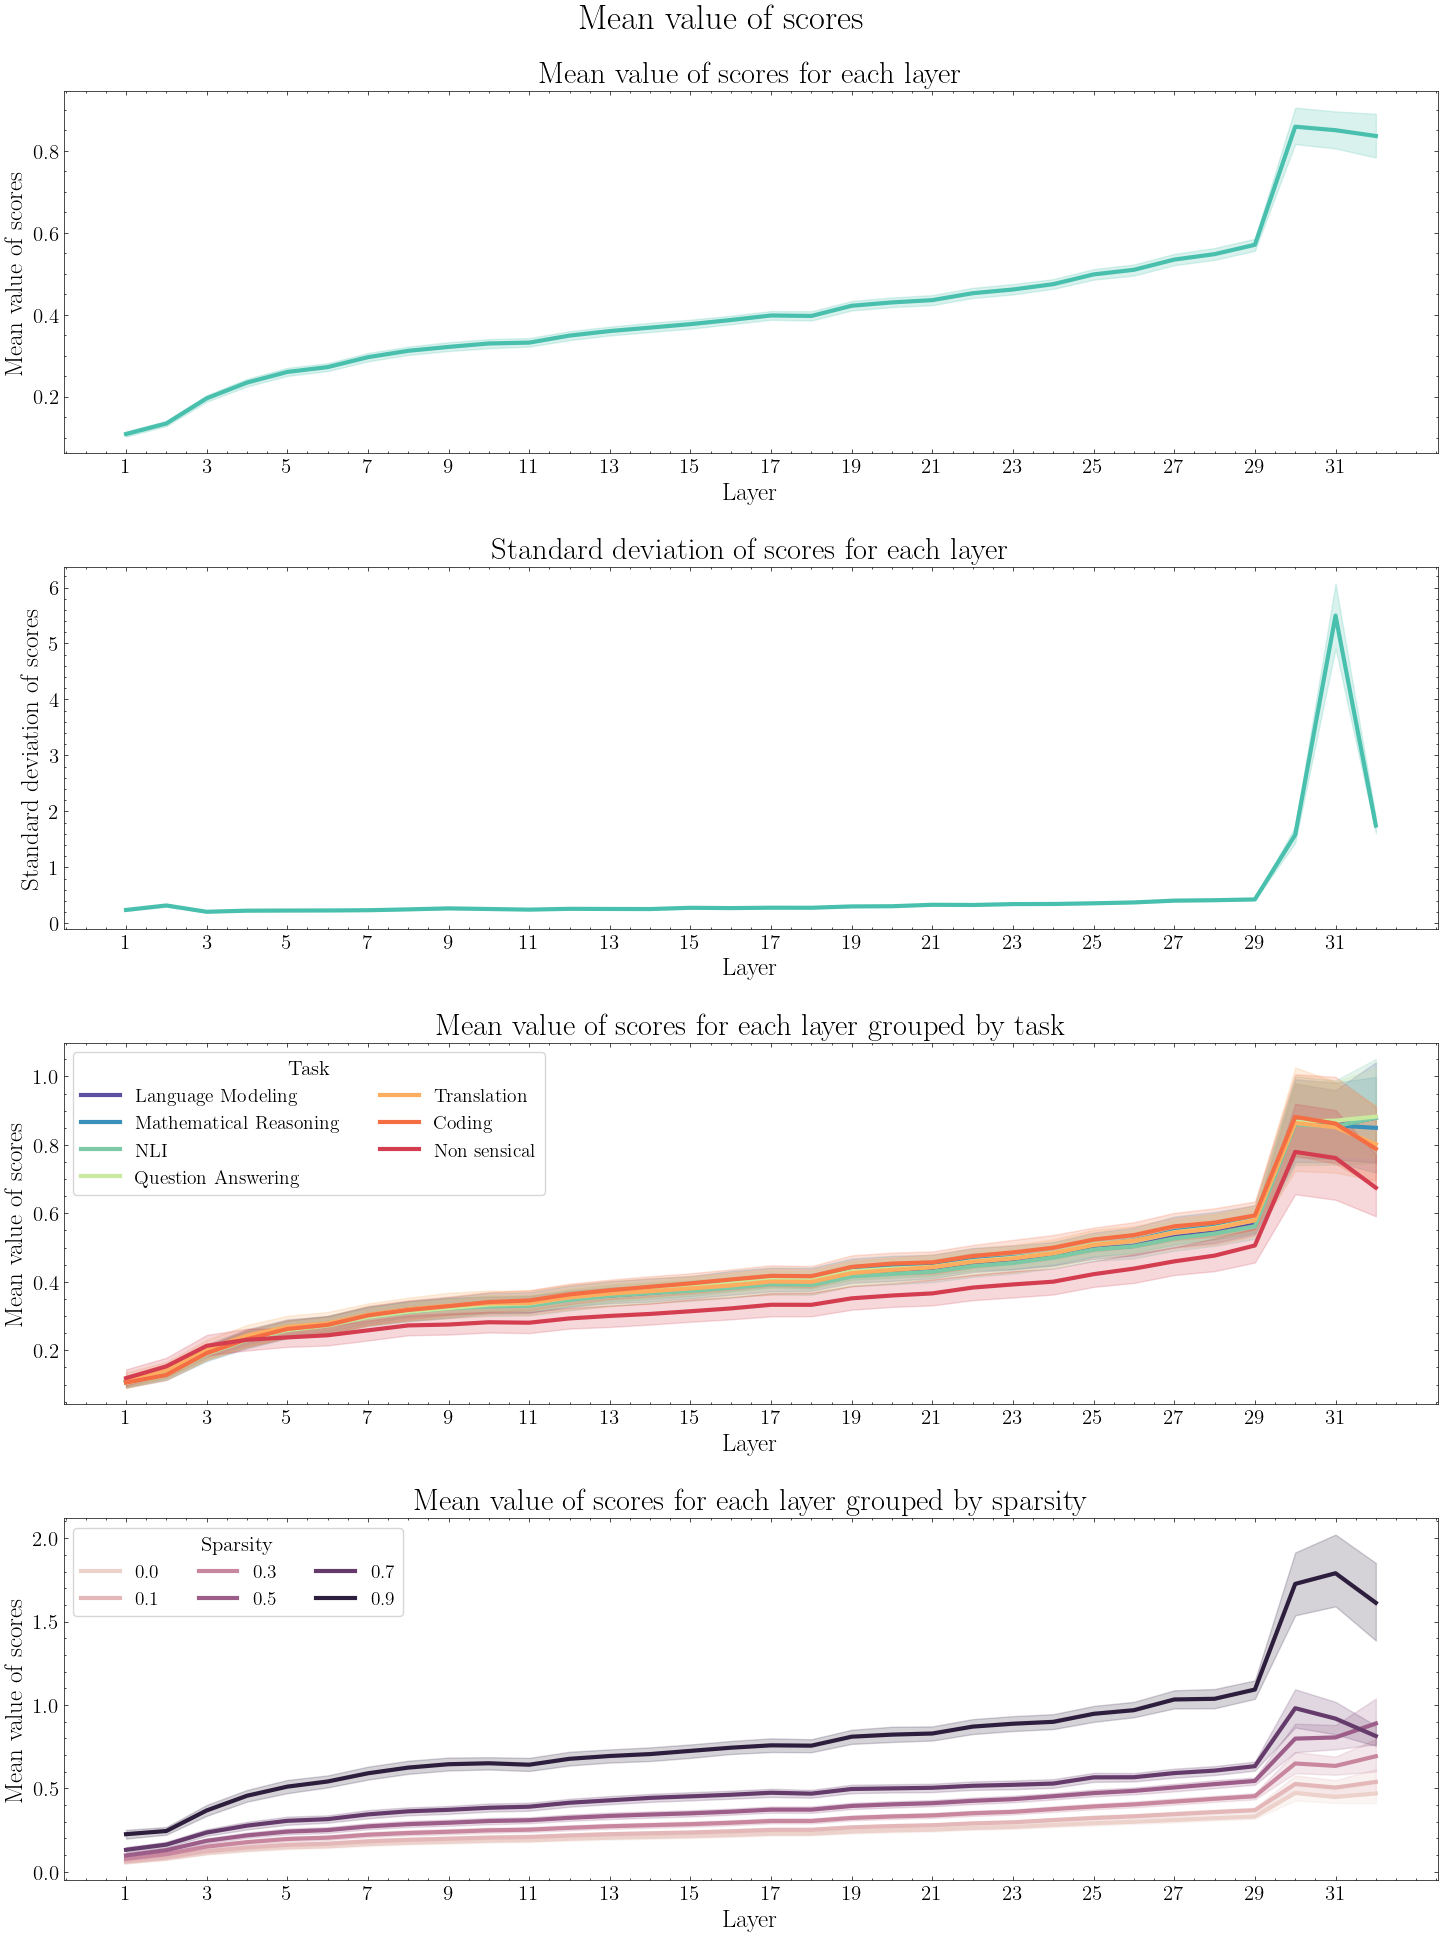

In [15]:
figure, ax = plt.subplots(4, figsize=(15, 20))

mean_result_across_datasets = data_weight_value.groupby(["model", "layer", "components", "sparsity", "dataset", "category"]).mean(numeric_only=True).reset_index()


#Show the distribution between 0 and 1
this_data_no_non_sensical = mean_result_across_datasets[mean_result_across_datasets["category"] != "non_sensical"]
this_data_no_non_sensical = this_data_no_non_sensical[this_data_no_non_sensical["model"] != "Qwen2.5-7B"]

sns.lineplot(data=this_data_no_non_sensical, x="layer", y="value", color=one_color, ax=ax[0], linewidth=3)
ax[0].set_title("Mean value of scores for each layer")
ax[0].set_ylabel("Mean value of scores")
ax[0].set_xlabel("Layer")
ax[0].set_xticks(range(0,32,2))
ax[0].set_xticklabels([i for i in range(1,33,2)])


sns.lineplot(data=this_data_no_non_sensical, x="layer", y="value_std", color=one_color, ax=ax[1], linewidth=3)
ax[1].set_title("Standard deviation of scores for each layer")
ax[1].set_ylabel("Standard deviation of scores")
ax[1].set_xlabel("Layer")
ax[1].set_xticks(range(0,32,2))
ax[1].set_xticklabels([i for i in range(1,33,2)])

sns.lineplot(data=mean_result_across_datasets[mean_result_across_datasets["model"] != "Qwen2.5-7B"], x="layer", y="value", hue="category", palette=custom_palette, ax=ax[2], hue_order = all_categories_names_print, linewidth=3)
ax[2].set_title("Mean value of scores for each layer grouped by task")
ax[2].set_ylabel("Mean value of scores")
ax[2].set_xlabel("Layer")
ax[2].legend(title="Task", loc='upper left', title_fontsize=15, fontsize=14, ncol=2, frameon=True)
ax[2].set_xticks(range(0,32,2))
ax[2].set_xticklabels([i for i in range(1,33,2)])

sns.lineplot(data=this_data_no_non_sensical, x="layer", y="value", hue="sparsity", ax=ax[3], linewidth=3)
ax[3].set_title("Mean value of scores for each layer grouped by sparsity")
ax[3].set_ylabel("Mean value of scores")
ax[3].set_xlabel("Layer")
ax[3].legend(title="Sparsity", loc='upper left',  title_fontsize=15, fontsize=14, ncol=3, frameon=True)
ax[3].set_xticks(range(0,32,2))
ax[3].set_xticklabels([i for i in range(1,33,2)])

figure.suptitle("Mean value of scores", fontsize=25)
figure.tight_layout(pad=2.0)



/var/folders/k2/frn908kd4_q13s9qm8hj9zcw0000gn/T/ipykernel_5846/4283482214.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_data_no_non_sensical_model["components"] = this_data_no_non_sensical_model["components"].map(lambda x: dictionary_components[model][int(x)])
/var/folders/k2/frn908kd4_q13s9qm8hj9zcw0000gn/T/ipykernel_5846/4283482214.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_data_no_non_sensical_model["components"] = this_data_no_non_sensical_model["components"].map(lambda x: dict

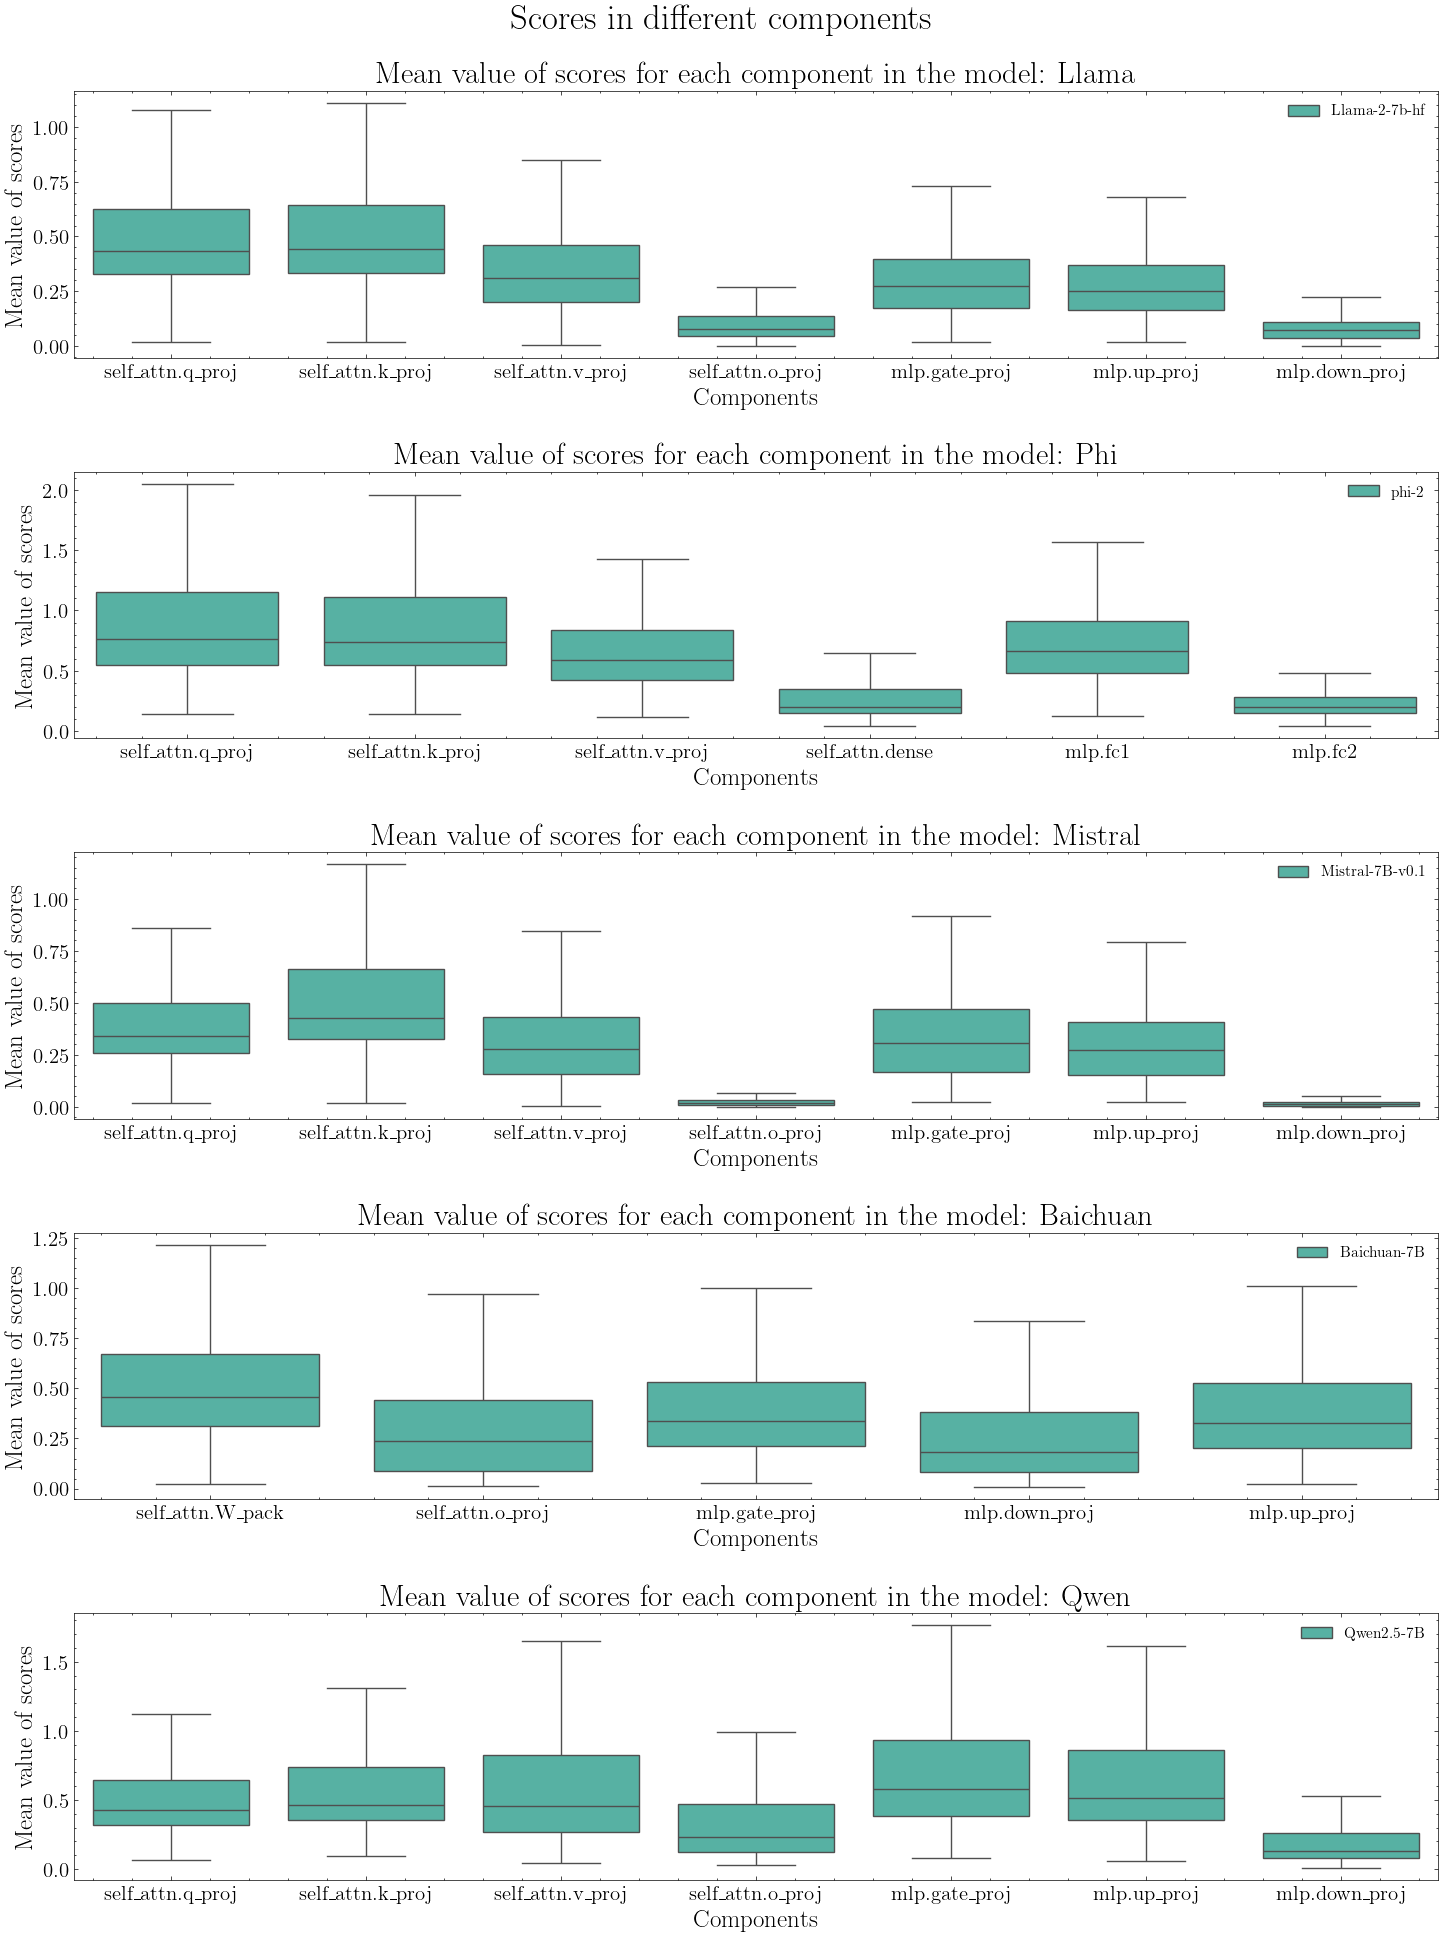

In [16]:
figure, ax = plt.subplots(5, figsize=(15, 20))

mean_result_across_datasets = data_weight_value.groupby(["model", "layer", "components", "sparsity", "dataset", "category"]).mean(numeric_only=True).reset_index()
this_data_no_non_sensical = mean_result_across_datasets[mean_result_across_datasets["category"] != "non_sensical"]

for index, model in enumerate(model_list):
    this_data_no_non_sensical_model = this_data_no_non_sensical[this_data_no_non_sensical["model"] == model]
    
    this_data_no_non_sensical_model["components"] = this_data_no_non_sensical_model["components"].map(lambda x: dictionary_components[model][int(x)])
    sns.boxplot(data=this_data_no_non_sensical_model, x="components", y="value", color=one_color, ax=ax[index], label=model, showfliers=False)
    ax[index].set_title("Mean value of scores for each component in the model: {}".format(models_names_print[index]))
    ax[index].set_xlabel("Components")
    ax[index].set_ylabel("Mean value of scores")

figure.suptitle("Scores in different components", fontsize=25)
figure.tight_layout(pad=2.0)
